My take on the BWAS paper by Marek and coll.: heterogeneity maybe as important as statistical power. A reproducible thread (binder code: https://mybinder.org/v2/gh/pbellec/bwas_simulation/HEAD?labpath=bwas_simulation.ipynb). Background: thread https://twitter.com/tervoclemmensb/status/1504145481584287746?s=20&t=B7iaoLL-N1ChmhIsXOgcdA and paper https://www.nature.com/articles/s41586-022-04492-9 1/n

Note that the implementation of simulations favors readability over efficiency. This notebook will take a few minutes to re-execute, but could likely run <1 sec by avoiding for loops.

Basics first: correlation between brain and behavior (here true r=0.2) may vary a lot across samples. Variability becomes moderate at N~200+, small for N>1k. Sobering but well known: @IMMAlab et al. 2012  https://europepmc.org/article/PMC/3882689 and 🧵 by @tenphotos https://twitter.com/ten_photos/status/1504801784199585796?s=20&t=zaHhnKYED8jIhdTl3Gjqkw 2/n

32
64
128
256
512
1024
2048
4096


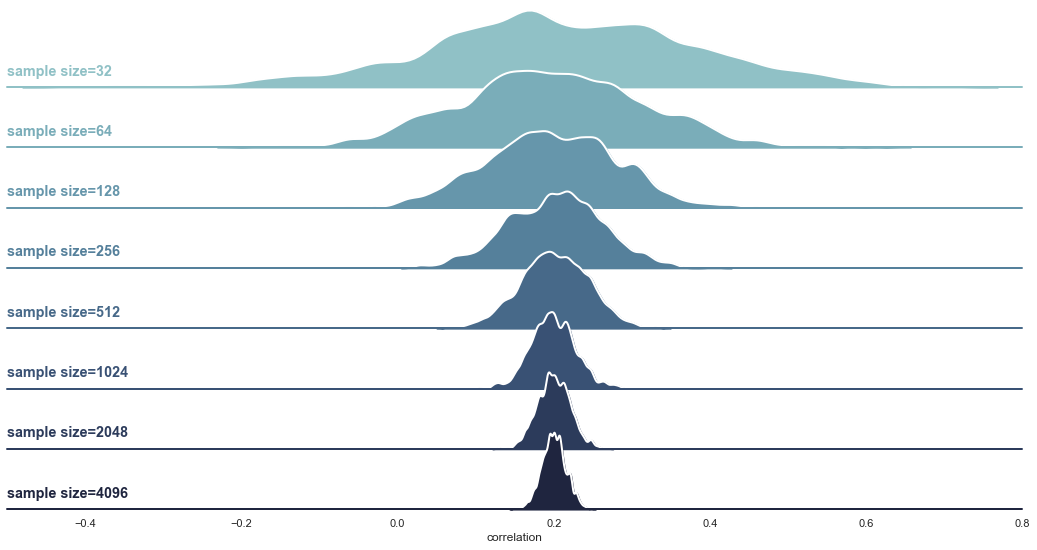

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Simulation parameters 
#######################

# List of sample sizes we're going to test
list_n_sample = np.power(2, range(5, 13))
# Number of replications for the experiment
n_replication = 1000
# Ground truth value for the correlation
rho = 0.2


# Helper functions 
##################
def _replicate_correlation(n_replication, n_sample, rho):
    """Replicate correlation with known true value and fixed sample size"""
    simulation = []
    for replication in range(n_replication):
        # Generate two series following multivariate normal distribution
        series = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], size=[n_sample, ])
        # Compute the empirical correlation between the two series
        r = np.corrcoef(series.transpose())
        simulation.append(r[0, 1])
    return np.array(simulation)
        

# Define and use a simple function to label the plot in axes coordinates
def _label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f"sample size={label}", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, size='large')

    
def _visu_distribution(df, list_n_sample, rho, xlim=None):
    """Visualize distributions of r replications with ridge plots"""
    # Code adapted from seaborn docs https://seaborn.pydata.org/examples/kde_ridgeplot.html
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(len(list_n_sample), rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="n_sample", hue="n_sample", aspect=15, height=1, palette=pal, sharey=False)
    g.map(_label, "n_sample")
    g.map(sns.kdeplot, "correlation",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "correlation", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    if not xlim == None:
        g.set(xlim=xlim)
    
# Run simulations 
#################
all_simulation = pd.DataFrame(columns=['n_sample', 'correlation'])
for num, n_sample in enumerate(list_n_sample):
    print(n_sample)    
    all_simulation.loc[num, 'correlation'] = _replicate_correlation(n_replication, n_sample, rho)
    all_simulation.loc[num, 'n_sample'] = n_sample
    
# Visualize distributions 
_visu_distribution(all_simulation.explode('correlation', ignore_index=True), list_n_sample, rho, xlim=(-0.5, 0.8))

If we screen many (say 300) brain regions (BWAS) and only focus on the top 10% with the strongest associations, we get inflated correlations (large inflation for small Ns, moderate for N>1000). See the landmark Hu et al. https://doi.org/10.1111%2Fj.1745-6924.2009.01125.x. 3/n

32
64
128
256
512
1024
2048
4096


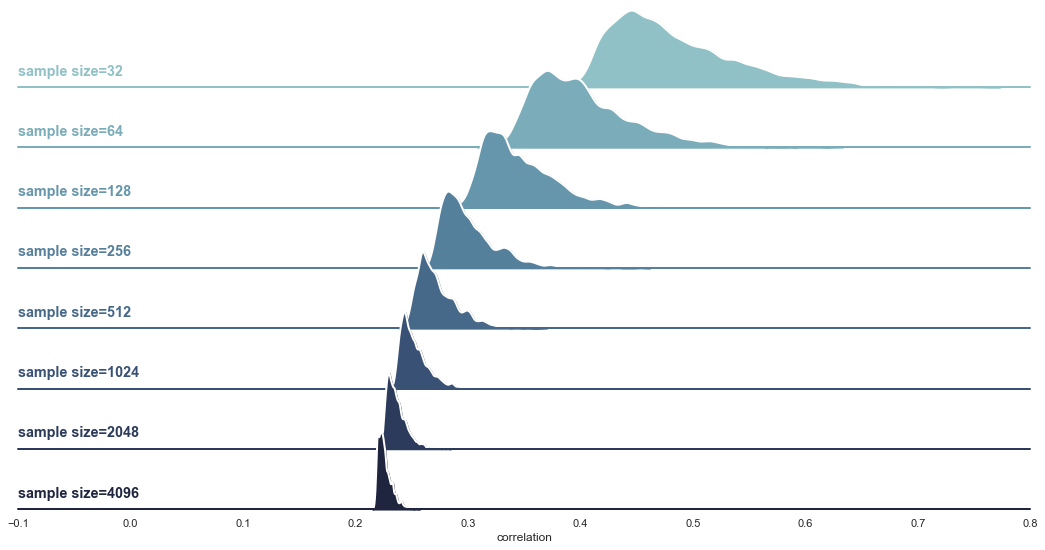

In [2]:
# Additional simulation parameters 
##################################
# We can reduce the number of replications, because screening itself returns many replications
n_replication = 50
# Number of regions for BWAS
n_region = 300
# Screening parameter for BWAS
top_percentile = 0.1

top_region = int(np.ceil(top_percentile * n_region))

# Helper function 
#################
def _replicate_correlation_bwas(n_replication, n_sample, rho, top_region):
    """Replicate correlation with known true value and fixed sample size, after screening through BWAS"""    
    simulation_region = []
    for region in range(n_region):
        series = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], size=[n_sample, ])
        r = np.corrcoef(series.transpose())
        simulation_region.append(-r[0, 1])
    simulation_region = np.sort(simulation_region)
    simulation_region = -simulation_region[0:top_region]
    return np.array(simulation_region)

# Run simulations
all_simulation = pd.DataFrame(columns=['n_sample', 'correlation'])
for num, n_sample in enumerate(list_n_sample):
    simulation = np.zeros([n_replication, top_region])
    print(n_sample)
    for replication in range(n_replication):
        simulation[replication, :] = _replicate_correlation_bwas(n_replication, n_sample, rho, top_region)         
    all_simulation.loc[num, 'correlation'] = simulation.reshape([n_replication * top_region, ])
    all_simulation.loc[num, 'n_sample'] = n_sample

# Visualize distributions 
_visu_distribution(all_simulation.explode('correlation', ignore_index=True), list_n_sample, rho, xlim=(-0.1, 0.8))

Cross validation can eliminate the BWAS sample-dependent bias. First identify the top regions on a train set, then estimate `r` for these regions in a separate, held-out test set. This fix was notably advocated by Hu et al.  https://doi.org/10.1111%2Fj.1745-6924.2009.01125.x 4/n

32
64
128
256
512
1024
2048
4096


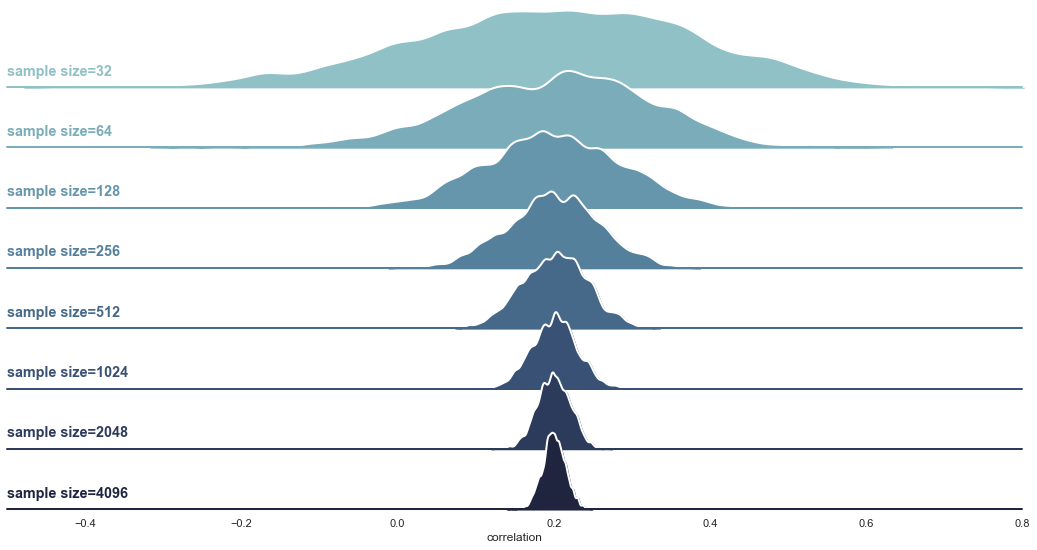

In [3]:
# Helper function 
#################
def _sample_mixture(rho1, n_sample, prob1=1, rho2=None):
    """Generate subject data with a mixture of underlying correlation"""
    if prob1 < 1:
        n_sample1 = np.sum(np.random.rand(n_sample) < prob1)
        series = np.random.multivariate_normal([0, 0], [[1, rho1], [rho1, 1]], size=[n_sample1, ])
        series2 = np.random.multivariate_normal([0, 0], [[1, rho2], [rho2, 1]], size=[n_sample - n_sample1, ])
        series = np.concatenate([series, series2], axis=0)
    else:
        series = np.random.multivariate_normal([0, 0], [[1, rho1], [rho1, 1]], size=[n_sample, ])
    return series
    

def _crossvalidation_correlation_bwas(n_replication, n_sample, rho, top_region, prob1=1, rho2=None):
    """Replicate correlation after screening through BWAS with cross-validation"""    
    simulation_region = []
    simulation_region2 = []
    for region in range(n_region):
        series = _sample_mixture(rho, n_sample, prob1, rho2)
        series2 = _sample_mixture(rho, n_sample, prob1, rho2)
        r = np.corrcoef(series.transpose())
        r2 = np.corrcoef(series2.transpose())
        simulation_region.append(-r[0, 1])
        simulation_region2.append(-r2[0, 1])
    index = np.argsort(simulation_region)       
    return -np.array(simulation_region2)[index[0:top_region]]

# Run simulations
#################
all_simulation = pd.DataFrame(columns=['n_sample', 'correlation'])
for num, n_sample in enumerate(list_n_sample):
    simulation = np.zeros([n_replication, top_region])
    print(n_sample)
    for replication in range(n_replication):           
        simulation[replication, :] = _crossvalidation_correlation_bwas(n_replication, n_sample, rho, top_region)
    all_simulation.loc[num, 'correlation'] = simulation.reshape([n_replication * top_region, ])
    all_simulation.loc[num, 'n_sample'] = n_sample
    
# Visualize distributions 
_visu_distribution(all_simulation.explode('correlation', ignore_index=True), list_n_sample, rho, xlim=(-0.5, 0.8))    

Now, about heterogeneity. Imagine we have two subtypes: one dominant with r=0.1 (80% of the sample), and an atypical r=0.6 (20% of the sample). When you combine the two subtypes and run the same BWAS at before, everything looks exactly like an r=0.2 simulation! 5/n

32
64
128
256
512
1024
2048
4096


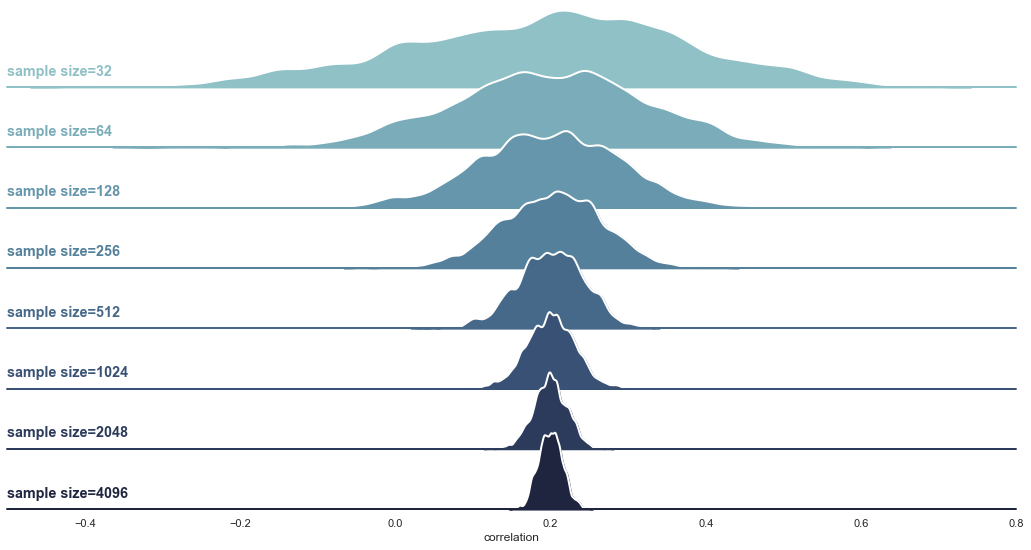

In [4]:
# Additional simulation parameters 
##################################
# Correlation in dominant subtype
rho = 0.1
# Prevalence of dominant subtype
prob = .8
# Correlation in rare subtype
rho2 = .6

# Run simulations
#################
all_simulation = pd.DataFrame(columns=['n_sample', 'correlation'])
for num, n_sample in enumerate(list_n_sample):
    simulation = np.zeros([n_replication, top_region])
    print(n_sample)
    for replication in range(n_replication):           
        simulation[replication, :] = _crossvalidation_correlation_bwas(n_replication, n_sample, rho, top_region, prob, rho2)
    all_simulation.loc[num, 'correlation'] = simulation.reshape([n_replication * top_region, ])
    all_simulation.loc[num, 'n_sample'] = n_sample
    
# Visualize distributions 
_visu_distribution(all_simulation.explode('correlation', ignore_index=True), list_n_sample, rho, xlim=(-0.5, 0.8))    

If we could enrich with 20% case A and 80% case B, we would get much larger associations. Just a thought experiment? No. Clinically depressed, individuals on the spectrum or individuals with fronto-temporal demential have small prevalence in population samples. 6/n

32
64
128
256
512
1024
2048
4096


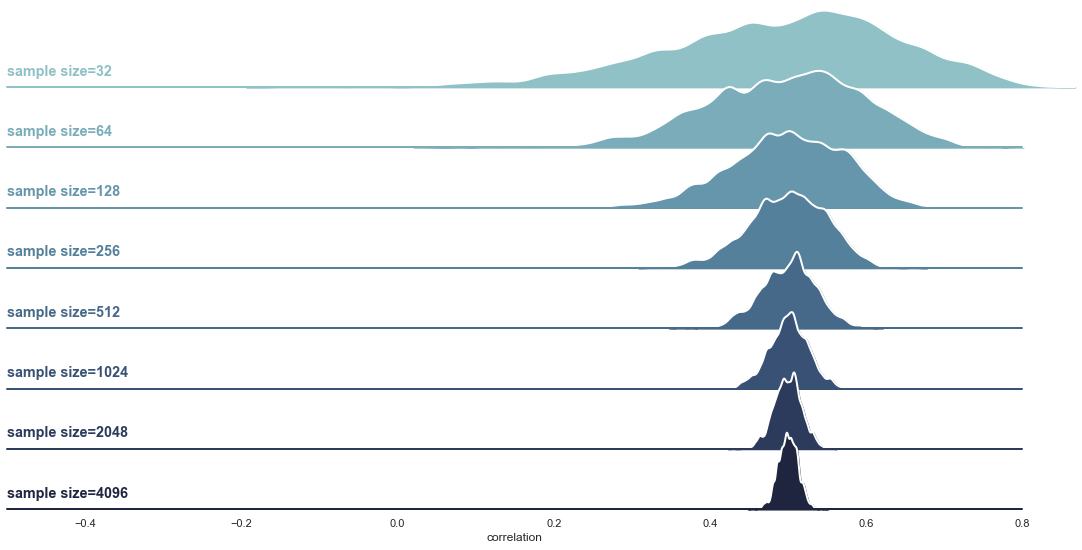

In [5]:
# Additional simulation parameters 
##################################
# Correlation in dominant subtype
rho = 0.1
# Prevalence of dominant subtype
prob = .2
# Correlation in rare subtype
rho2 = .6

# Run simulations
#################
all_simulation = pd.DataFrame(columns=['n_sample', 'correlation'])
for num, n_sample in enumerate(list_n_sample):
    simulation = np.zeros([n_replication, top_region])
    print(n_sample)
    for replication in range(n_replication):           
        simulation[replication, :] = _crossvalidation_correlation_bwas(n_replication, n_sample, rho, top_region, prob, rho2)
    all_simulation.loc[num, 'correlation'] = simulation.reshape([n_replication * top_region, ])
    all_simulation.loc[num, 'n_sample'] = n_sample
    
# Visualize distributions 
_visu_distribution(all_simulation.explode('correlation', ignore_index=True), list_n_sample, rho, xlim=(-0.5, 0.8))    


There is I believe convincing evidence of case-control differences in clinical samples, even in small N, e.g. 22q11.2 CNV. See recent work with @ClaraMoreau9 @JacquemontSeb and coll. https://www.medrxiv.org/content/10.1101/2021.05.21.21257604v1 and thread by @PTenigma https://twitter.com/PTenigma/status/1505087664445403136?s=20&t=zaHhnKYED8jIhdTl3Gjqkw 7/n

In conclusion, methods for handling heterogeneity are needed to relate brain and behavior in large samples. BWAS with a single behavioural measure will likely not cut it, even with thousands of subjects. n/n